In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import math 
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import scipy.stats as sps

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import statsmodels.api as sm

In [4]:
#SciServer Modules
import SciServer
from SciServer import CasJobs

In [5]:
Candidates = """select drp.MaNGAid,
                drp.nsa_elpetro_mass as GalMass,
                drp.z,
                drp.nsa_elpetro_absmag_u as uMag, 
                drp.nsa_elpetro_absmag_r as rMag,
                firefly.LW_AGE_1RE as LWStellarAge
                
                
                from mangaDRPall as drp
                
                JOIN mangaDAPall as dap on dap.mangaid = drp.mangaid

                JOIN mangaFirefly_mastar as firefly on drp.mangaid = firefly.MANGAID
                                
                WHERE (drp.z < 0.15) and (drp.z > 0.001) 
                and dap.daptype = 'HYB10-MILESHC-MASTARHC2' 
                and (drp.nsa_elpetro_mass < 5e+9)"""

Dwarfs = CasJobs.executeQuery(Candidates, 'dr17')
print(Dwarfs)

CandidateIDs = Dwarfs['MaNGAid']
CandidateMasses = Dwarfs['GalMass']
CandidateZs = Dwarfs['z']
CandidateMags = Dwarfs['uMag'] - Dwarfs['rMag']
lwCandidateAges = Dwarfs['LWStellarAge']

       MaNGAid       GalMass         z      uMag      rMag  LWStellarAge
0     1-122310  1.874750e+09  0.021218 -16.50110 -18.17540      0.489009
1     1-232157  3.986630e+09  0.022803 -16.43550 -18.66470      0.743334
2     1-183449  1.292940e+09  0.022881 -16.94240 -18.04010      0.191668
3      1-79490  2.964780e+09  0.040090 -17.59620 -18.82270  -9999.000000
4     1-456664  8.130359e+08  0.022926 -15.21014 -17.17817      0.459903
...        ...           ...       ...       ...       ...           ...
3671  1-456929  1.670510e+09  0.020867 -15.41570 -17.72750      0.808366
3672  1-456861  1.430400e+09  0.023515 -16.66020 -17.61070  -9999.000000
3673  1-456957  3.363920e+09  0.027346 -16.44140 -18.56400      0.567530
3674  1-404292  2.905170e+09  0.021389 -16.36050 -18.36570      0.660408
3675  1-456896  8.361030e+08  0.023583 -12.91780 -17.17680  -9999.000000

[3676 rows x 6 columns]


In [6]:
#List of ID, Galaxy Mass, z, Magnitude, and Average Stellar Age for all Candidates

ID = []
GalMass = []
Redshift =[]
GalMag = []
lwAvgStelAge = []
GALINFO_RAW = []

for i in range(len(CandidateIDs)):
    ID.append([CandidateIDs[i]])

for i in range(len(CandidateMasses)):
    GalMass.append([CandidateMasses[i]])
    
for i in range(len(CandidateZs)):
    Redshift.append([CandidateZs[i]])

for i in range(len(CandidateMags)):
    GalMag.append([CandidateMags[i]])

for i in range(len(lwCandidateAges)):
    lwAvgStelAge.append([lwCandidateAges[i]])
    
    
print('No. of MaNGA IDs: ' + str(len(ID)))
print('No. of Galaxy Mass Values: ' + str(len(GalMass)))
print('No. of Redshift Values: ' + str(len(Redshift)))
print('No. of Magnitude Values: ' + str(len(GalMag)))
print('No. of Light Weighted Stellar Age Values: ' + str(len(lwAvgStelAge)))
for i in range(len(CandidateIDs)):
    GALINFO_RAW.append([CandidateIDs[i]])
    GALINFO_RAW.append([CandidateMasses[i]])
    GALINFO_RAW.append([CandidateZs[i]])
    GALINFO_RAW.append([CandidateMags[i]])
    GALINFO_RAW.append([lwCandidateAges[i]])

print(GALINFO_RAW)

No. of MaNGA IDs: 3676
No. of Galaxy Mass Values: 3676
No. of Redshift Values: 3676
No. of Magnitude Values: 3676
No. of Light Weighted Stellar Age Values: 3676
[['1-122310'], [1874750000.0], [0.0212176], [1.6742999999999988], [0.4890085], ['1-232157'], [3986630000.0], [0.0228034], [2.2291999999999987], [0.7433342], ['1-183449'], [1292940000.0], [0.0228812], [1.0976999999999997], [0.1916679], ['1-79490'], [2964780000.0], [0.0400896], [1.2265000000000015], [-9999.0], ['1-456664'], [813035900.0], [0.02292592], [1.9680300000000006], [0.4599027], ['1-152133'], [510154000.0], [0.01600367], [1.6173400000000004], [0.3885771], ['1-152247'], [2383671000.0], [0.03470836], [2.3223199999999977], [0.6546807], ['1-152235'], [3709510000.0], [0.02386081], [1.3179300000000005], [0.2633864], ['1-605750'], [2317459000.0], [0.02322944], [2.921240000000001], [0.8004506], ['1-1151'], [2053367000.0], [0.04464796], [1.0959399999999988], [0.1321348], ['1-135027'], [530492500.0], [0.032], [1.0691299999999977], 

In [7]:
##========================================================AGN SORTING=========================================================##

In [8]:
#Creating list of dwarf galaxy AGN IDs
AGNIDs_DF = pd.read_excel('Dwarf_AGN_ID.xlsx')
AGNIDs = pd.DataFrame(AGNIDs_DF)
AGNIDs = AGNIDs.values.tolist()

AGNID = []

for i in range(len(AGNIDs)):
    AGNID.append(AGNIDs[i])
    
print('Target number of AGN Galaxies: ' + str(len(AGNID)) + '\n')
print('MaNGA IDs: ' + str(AGNID))

Target number of AGN Galaxies: 531

MaNGA IDs: [['1-384250'], ['1-35840'], ['1-36587'], ['1-183465'], ['1-77738'], ['1-411'], ['1-456731'], ['1-403702'], ['1-397462'], ['1-456771'], ['1-335253'], ['1-545946'], ['1-117694'], ['1-135577'], ['1-115371'], ['1-38157'], ['1-38310'], ['1-42274'], ['1-201180'], ['1-138164'], ['1-281125'], ['1-403634'], ['1-256125'], ['1-231847'], ['1-189376'], ['1-213739'], ['1-53985'], ['1-53985'], ['1-457072'], ['1-456816'], ['1-456983'], ['1-456734'], ['1-457182'], ['54-25'], ['1-576554'], ['1-225'], ['1-96081'], ['1-415391'], ['1-138401'], ['1-10263'], ['1-113219'], ['1-179724'], ['1-38514'], ['1-147394'], ['1-281404'], ['1-210966'], ['1-248352'], ['1-210112'], ['1-523027'], ['1-261200'], ['1-252073'], ['1-383825'], ['1-384189'], ['1-229976'], ['1-36267'], ['1-72402'], ['1-412393'], ['1-174951'], ['1-150938'], ['1-457376'], ['1-455637'], ['1-404173'], ['1-244785'], ['1-456378'], ['1-24055'], ['1-299337'], ['1-543446'], ['1-151797'], ['1-176155'], ['1-53622

In [9]:
AGN_ID = []
AGN_GalMass = []
AGN_Redshift = []
AGN_Magnitude = []
AGN_lwAvgStelAge = []

AGN_GalCount = 0 #Number of galaxies

for i in range(len(AGNID)):
    for x in range(len(ID)):
        if (AGNID[i] == ID[x]):
            AGN_ID.append(ID[x])
            AGN_GalMass.append(GalMass[x])
            AGN_Redshift.append(Redshift[x])
            AGN_Magnitude.append(GalMag[x])
            AGN_lwAvgStelAge.append(lwAvgStelAge[x])
            AGN_GalCount+=1
            break
            
print('AGN Dominated Galaxy Count: ' + str(AGN_GalCount))
print('IDs: ' + str(AGN_ID) + '\n')
print('Masses: ' + str(AGN_GalMass) + '\n')
print('Redshifts: ' + str(AGN_Redshift) + '\n')
print('Magnitudes: ' + str(AGN_Magnitude) + '\n')
print('Light Weighted Ages: ' + str(AGN_lwAvgStelAge) + '\n')

AGN Dominated Galaxy Count: 530
IDs: [['1-384250'], ['1-35840'], ['1-36587'], ['1-183465'], ['1-77738'], ['1-411'], ['1-456731'], ['1-403702'], ['1-397462'], ['1-456771'], ['1-335253'], ['1-545946'], ['1-117694'], ['1-135577'], ['1-115371'], ['1-38157'], ['1-38310'], ['1-42274'], ['1-201180'], ['1-138164'], ['1-281125'], ['1-403634'], ['1-256125'], ['1-231847'], ['1-189376'], ['1-213739'], ['1-53985'], ['1-53985'], ['1-457072'], ['1-456816'], ['1-456983'], ['1-456734'], ['1-457182'], ['54-25'], ['1-576554'], ['1-225'], ['1-96081'], ['1-415391'], ['1-138401'], ['1-10263'], ['1-113219'], ['1-179724'], ['1-38514'], ['1-147394'], ['1-281404'], ['1-248352'], ['1-210112'], ['1-523027'], ['1-261200'], ['1-252073'], ['1-383825'], ['1-384189'], ['1-229976'], ['1-36267'], ['1-72402'], ['1-412393'], ['1-174951'], ['1-150938'], ['1-457376'], ['1-455637'], ['1-404173'], ['1-244785'], ['1-456378'], ['1-24055'], ['1-299337'], ['1-543446'], ['1-151797'], ['1-176155'], ['1-53622'], ['1-456297'], ['1-25

In [10]:
#Removing brackets from element

for i in range(len(AGN_ID)):
    AGN_ID[i] = str(AGN_ID[i])[1:]
    AGN_ID[i] = str(AGN_ID[i])[:-1]
    
for i in range(len(AGN_GalMass)):
    AGN_GalMass[i] = str(AGN_GalMass[i])[1:]
    AGN_GalMass[i] = str(AGN_GalMass[i])[:-1]
    
for i in range(len(AGN_Redshift)):
    AGN_Redshift[i] = str(AGN_Redshift[i])[1:]
    AGN_Redshift[i] = str(AGN_Redshift[i])[:-1]

for i in range(len(AGN_Magnitude)):
    AGN_Magnitude[i] = str(AGN_Magnitude[i])[1:]
    AGN_Magnitude[i] = str(AGN_Magnitude[i])[:-1]

for i in range(len(AGN_lwAvgStelAge)):
    AGN_lwAvgStelAge[i] = str(AGN_lwAvgStelAge[i])[1:]
    AGN_lwAvgStelAge[i] = str(AGN_lwAvgStelAge[i])[:-1]
    

    
     
print(AGN_ID)
print(AGN_GalMass)
print(AGN_Redshift)
print(AGN_Magnitudes)
print(AGN_lwAvgStelAge)

["'1-384250'", "'1-35840'", "'1-36587'", "'1-183465'", "'1-77738'", "'1-411'", "'1-456731'", "'1-403702'", "'1-397462'", "'1-456771'", "'1-335253'", "'1-545946'", "'1-117694'", "'1-135577'", "'1-115371'", "'1-38157'", "'1-38310'", "'1-42274'", "'1-201180'", "'1-138164'", "'1-281125'", "'1-403634'", "'1-256125'", "'1-231847'", "'1-189376'", "'1-213739'", "'1-53985'", "'1-53985'", "'1-457072'", "'1-456816'", "'1-456983'", "'1-456734'", "'1-457182'", "'54-25'", "'1-576554'", "'1-225'", "'1-96081'", "'1-415391'", "'1-138401'", "'1-10263'", "'1-113219'", "'1-179724'", "'1-38514'", "'1-147394'", "'1-281404'", "'1-248352'", "'1-210112'", "'1-523027'", "'1-261200'", "'1-252073'", "'1-383825'", "'1-384189'", "'1-229976'", "'1-36267'", "'1-72402'", "'1-412393'", "'1-174951'", "'1-150938'", "'1-457376'", "'1-455637'", "'1-404173'", "'1-244785'", "'1-456378'", "'1-24055'", "'1-299337'", "'1-543446'", "'1-151797'", "'1-176155'", "'1-53622'", "'1-456297'", "'1-258915'", "'1-334462'", "'1-294564'", "

NameError: name 'AGN_Magnitudes' is not defined

In [11]:
#Information is stored in a 4D array detailed below

                             #**SO FAR ONLY MANGA ID, GALAXY MASS, AND REDSHIFT ARE IN THE LIST**# 
                    ########################################################################################                 
                    #                                                                                      #
                    # #==========INDEX-0=====INDEX-1======INDEX-2=======INDEX-3=============INDEX-4        #
                    #                                                                                      #
                    # #INDEX-0  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-1  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-2  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX...                                                                            #
                    ########################################################################################           
                        
AGN_GALAXIES_CONDENSED = np.array(list(zip(AGN_ID, AGN_GalMass, AGN_Redshift, AGN_Magnitude, AGN_lwAvgStelAge)))
AGN_GALAXIES_CONDENSED = pd.DataFrame(AGN_GALAXIES_CONDENSED)
AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-384250',2554660000.0,0.0151598,1.6022999999999996,0.8024409
1,'1-35840',2899230000.0,0.0195127,2.169999999999998,0.5249886
2,'1-36587',4795180000.0,0.0229049,2.2473000000000027,0.8209693
3,'1-183465',4314150000.0,0.0260983,2.291800000000002,0.8163062
4,'1-77738',1815794000.0,0.0278854,2.0464399999999987,0.6255627
...,...,...,...,...,...
525,'1-198052',3764400000.0,0.0372651,2.388300000000001,0.8103434
526,'1-591279',506785000.0,0.020701,2.3187999999999995,-9999.0
527,'1-623893',4471510000.0,0.0273098,1.6204,0.1459308
528,'1-457151',2784450000.0,0.021117,2.395199999999999,0.7487585


In [12]:
#Changing values from strings to floats

for i in range(len(AGN_GALAXIES_CONDENSED)):
    AGN_GALAXIES_CONDENSED[1][i] = float(AGN_GALAXIES_CONDENSED[1][i])
    AGN_GALAXIES_CONDENSED[2][i] = float(AGN_GALAXIES_CONDENSED[2][i])
    AGN_GALAXIES_CONDENSED[3][i] = float(AGN_GALAXIES_CONDENSED[3][i])
    AGN_GALAXIES_CONDENSED[4][i] = float(AGN_GALAXIES_CONDENSED[4][i])

AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-384250',2.55466e+09,0.0151598,1.6023,0.802441
1,'1-35840',2.89923e+09,0.0195127,2.17,0.524989
2,'1-36587',4.79518e+09,0.0229049,2.2473,0.820969
3,'1-183465',4.31415e+09,0.0260983,2.2918,0.816306
4,'1-77738',1.81579e+09,0.0278854,2.04644,0.625563
...,...,...,...,...,...
525,'1-198052',3.7644e+09,0.0372651,2.3883,0.810343
526,'1-591279',5.06785e+08,0.020701,2.3188,-9999
527,'1-623893',4.47151e+09,0.0273098,1.6204,0.145931
528,'1-457151',2.78445e+09,0.021117,2.3952,0.748758


In [13]:
##======================================================NON-AGN SORTING=======================================================##

In [14]:
#Creating list of dwarf galaxy NON-AGN IDs
SFIDs_DF = pd.read_excel('Dwarf_SF_ID.xlsx')
SFIDs = pd.DataFrame(SFIDs_DF)
SFIDs = SFIDs.values.tolist()

SFID = []

for i in range(len(SFIDs)):
    SFID.append(SFIDs[i])
    
print('Target number of SF Galaxies: ' + str(len(SFID)) + '\n')
print('MaNGA IDs: ' + str(SFID))

Target number of SF Galaxies: 2372

MaNGA IDs: [['1-153412'], ['1-384306'], ['1-201961'], ['1-50666'], ['1-36448'], ['1-36298'], ['1-230987'], ['1-567457'], ['1-300663'], ['1-232151'], ['1-278195'], ['1-241291'], ['1-54506'], ['1-54655'], ['1-60719'], ['1-301386'], ['1-76813'], ['1-78143'], ['1-456942'], ['1-522063'], ['1-522093'], ['1-321149'], ['1-404136'], ['1-244163'], ['1-195917'], ['1-368219'], ['1-159265'], ['1-122203'], ['1-458686'], ['1-412279'], ['1-218748'], ['1-605721'], ['1-301541'], ['1-301561'], ['1-55093'], ['1-283108'], ['1-233389'], ['1-195370'], ['1-80575'], ['1-234285'], ['1-151205'], ['1-176258'], ['1-1363'], ['1-633967'], ['1-136024'], ['1-249612'], ['1-325866'], ['1-283638'], ['1-336081'], ['1-335102'], ['1-333784'], ['1-337228'], ['1-273098'], ['1-96307'], ['1-193038'], ['1-33617'], ['1-35323'], ['1-116990'], ['1-118491'], ['1-39995'], ['1-39946'], ['1-40776'], ['1-404898'], ['1-624292'], ['1-386759'], ['1-585493'], ['1-63597'], ['1-138181'], ['1-62169'], ['1-61

In [15]:
nonAGN_ID = []
nonAGN_GalMass = []
nonAGN_Redshift = []
nonAGN_Magnitude = []
nonAGN_lwAvgStelAge = []


nonAGN_GalCount = 0 #Number of galaxies

for i in range(len(SFID)):
    for x in range(len(ID)):
        if (SFID[i] == ID[x]):
            nonAGN_ID.append(ID[x])
            nonAGN_GalMass.append(GalMass[x])
            nonAGN_Redshift.append(Redshift[x])
            nonAGN_Magnitude.append(GalMag[x])
            nonAGN_lwAvgStelAge.append(lwAvgStelAge[x])
            nonAGN_GalCount+=1
            break
            
print('SF Dominated Galaxy Count: ' + str(nonAGN_GalCount))
print('IDs' + str(nonAGN_ID) + '\n')
print('Masses' + str(nonAGN_GalMass) + '\n')
print('Redshifts' + str(nonAGN_Redshift) + '\n')
print('Magnitudes: ' + str(nonAGN_Magnitude) + '\n')
print('Light Weighted Ages: ' + str(nonAGN_lwAvgStelAge) + '\n')

SF Dominated Galaxy Count: 2370
IDs[['1-153412'], ['1-384306'], ['1-201961'], ['1-50666'], ['1-36448'], ['1-36298'], ['1-230987'], ['1-567457'], ['1-300663'], ['1-232151'], ['1-278195'], ['1-241291'], ['1-54506'], ['1-54655'], ['1-60719'], ['1-301386'], ['1-76813'], ['1-78143'], ['1-456942'], ['1-522063'], ['1-522093'], ['1-321149'], ['1-404136'], ['1-244163'], ['1-195917'], ['1-368219'], ['1-159265'], ['1-122203'], ['1-458686'], ['1-412279'], ['1-218748'], ['1-605721'], ['1-301541'], ['1-301561'], ['1-55093'], ['1-283108'], ['1-233389'], ['1-195370'], ['1-80575'], ['1-234285'], ['1-151205'], ['1-176258'], ['1-1363'], ['1-633967'], ['1-136024'], ['1-249612'], ['1-325866'], ['1-283638'], ['1-336081'], ['1-335102'], ['1-333784'], ['1-337228'], ['1-273098'], ['1-96307'], ['1-193038'], ['1-33617'], ['1-35323'], ['1-116990'], ['1-118491'], ['1-39995'], ['1-39946'], ['1-40776'], ['1-404898'], ['1-624292'], ['1-386759'], ['1-585493'], ['1-63597'], ['1-138181'], ['1-62169'], ['1-61890'], ['1-7

In [16]:
#Removing brackets from element

for i in range(len(nonAGN_ID)):
    nonAGN_ID[i] = str(nonAGN_ID[i])[1:]
    nonAGN_ID[i] = str(nonAGN_ID[i])[:-1]
    
for i in range(len(nonAGN_GalMass)):
    nonAGN_GalMass[i] = str(nonAGN_GalMass[i])[1:]
    nonAGN_GalMass[i] = str(nonAGN_GalMass[i])[:-1]
    
for i in range(len(nonAGN_Redshift)):
    nonAGN_Redshift[i] = str(nonAGN_Redshift[i])[1:]
    nonAGN_Redshift[i] = str(nonAGN_Redshift[i])[:-1]

for i in range(len(nonAGN_Magnitude)):
    nonAGN_Magnitude[i] = str(nonAGN_Magnitude[i])[1:]
    nonAGN_Magnitude[i] = str(nonAGN_Magnitude[i])[:-1]

for i in range(len(nonAGN_lwAvgStelAge)):
    nonAGN_lwAvgStelAge[i] = str(nonAGN_lwAvgStelAge[i])[1:]
    nonAGN_lwAvgStelAge[i] = str(nonAGN_lwAvgStelAge[i])[:-1]



print(nonAGN_ID)
print(nonAGN_GalMass)
print(nonAGN_Redshift)
print(nonAGN_Magnitude)
print(nonAGN_lwAvgStelAge)

["'1-153412'", "'1-384306'", "'1-201961'", "'1-50666'", "'1-36448'", "'1-36298'", "'1-230987'", "'1-567457'", "'1-300663'", "'1-232151'", "'1-278195'", "'1-241291'", "'1-54506'", "'1-54655'", "'1-60719'", "'1-301386'", "'1-76813'", "'1-78143'", "'1-456942'", "'1-522063'", "'1-522093'", "'1-321149'", "'1-404136'", "'1-244163'", "'1-195917'", "'1-368219'", "'1-159265'", "'1-122203'", "'1-458686'", "'1-412279'", "'1-218748'", "'1-605721'", "'1-301541'", "'1-301561'", "'1-55093'", "'1-283108'", "'1-233389'", "'1-195370'", "'1-80575'", "'1-234285'", "'1-151205'", "'1-176258'", "'1-1363'", "'1-633967'", "'1-136024'", "'1-249612'", "'1-325866'", "'1-283638'", "'1-336081'", "'1-335102'", "'1-333784'", "'1-337228'", "'1-273098'", "'1-96307'", "'1-193038'", "'1-33617'", "'1-35323'", "'1-116990'", "'1-118491'", "'1-39995'", "'1-39946'", "'1-40776'", "'1-404898'", "'1-624292'", "'1-386759'", "'1-585493'", "'1-63597'", "'1-138181'", "'1-62169'", "'1-61890'", "'1-79756'", "'1-61727'", "'1-159682'", 

In [17]:
#Information is stored in a 4D array detailed below

                             #**SO FAR ONLY MANGA ID, GALAXY MASS, AND REDSHIFT ARE IN THE LIST**# 
                    ########################################################################################                 
                    #                                                                                      #
                    # #==========INDEX-0=====INDEX-1======INDEX-2=======INDEX-3=============INDEX-4        #
                    #                                                                                      #
                    # #INDEX-0  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-1  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX-2  MaNGA-ID   Galaxy Mass   Redshift   Galaxy Magnitude   Average Stellar Age #
                    # #INDEX...                                                                            #
                    ########################################################################################           
                        

nonAGN_GALAXIES_CONDENSED = np.array(list(zip(nonAGN_ID, nonAGN_GalMass, nonAGN_Redshift, nonAGN_Magnitude, nonAGN_lwAvgStelAge)))
nonAGN_GALAXIES_CONDENSED = pd.DataFrame(nonAGN_GALAXIES_CONDENSED)
nonAGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-153412',2332640000.0,0.0174922,1.4897000000000027,0.2718865
1,'1-384306',1530360000.0,0.0261091,1.7546,0.5384346
2,'1-201961',2878000000.0,0.0387427,2.229599999999998,0.7039376
3,'1-50666',4226870000.0,0.0291603,1.9697999999999993,0.3778787
4,'1-36448',2237890000.0,0.0383789,1.4770000000000003,0.1578356
...,...,...,...,...,...
2365,'1-198173',2234590000.0,0.0362692,1.2295000000000016,0.4503859
2366,'1-321165',2707380000.0,0.0358224,2.335000000000001,-9999.0
2367,'1-322159',1621060000.0,0.0187596,1.5854,0.3260376
2368,'1-322353',839052000.0,0.0184955,1.8046000000000006,0.3326083


In [18]:
#Changing values from strings to floats

for i in range(len(nonAGN_GALAXIES_CONDENSED)):
    nonAGN_GALAXIES_CONDENSED[1][i] = float(nonAGN_GALAXIES_CONDENSED[1][i])
    nonAGN_GALAXIES_CONDENSED[2][i] = float(nonAGN_GALAXIES_CONDENSED[2][i])
    nonAGN_GALAXIES_CONDENSED[3][i] = float(nonAGN_GALAXIES_CONDENSED[3][i])
    nonAGN_GALAXIES_CONDENSED[4][i] = float(nonAGN_GALAXIES_CONDENSED[4][i])
    
AGN_GALAXIES_CONDENSED

,0,1,2,3,4
0,'1-384250',2.55466e+09,0.0151598,1.6023,0.802441
1,'1-35840',2.89923e+09,0.0195127,2.17,0.524989
2,'1-36587',4.79518e+09,0.0229049,2.2473,0.820969
3,'1-183465',4.31415e+09,0.0260983,2.2918,0.816306
4,'1-77738',1.81579e+09,0.0278854,2.04644,0.625563
...,...,...,...,...,...
525,'1-198052',3.7644e+09,0.0372651,2.3883,0.810343
526,'1-591279',5.06785e+08,0.020701,2.3188,-9999
527,'1-623893',4.47151e+09,0.0273098,1.6204,0.145931
528,'1-457151',2.78445e+09,0.021117,2.3952,0.748758


In [19]:
print((AGN_GALAXIES_CONDENSED[1][0]))

2554660000.0


In [20]:
##===================================================MATCHING NON-AGN TO AGN==================================================##

In [21]:
AGN_PAIR_HALFS_LW = []
nonAGN_PAIR_HALFS_LW = []

MassThreshold = 0.1
zThreshold = 0.05
MagThreshold = 0.25

PairCount = 0

for i in range(len(AGN_GALAXIES_CONDENSED)):
    for x in range(len(nonAGN_GALAXIES_CONDENSED)):
        if ((nonAGN_GALAXIES_CONDENSED[4][x] not in nonAGN_PAIR_HALFS_LW)
                and
            ((AGN_GALAXIES_CONDENSED[4][i] > -1) and (nonAGN_GALAXIES_CONDENSED[4][x] > -1))
                and
            (((AGN_GALAXIES_CONDENSED[1][i]) - (AGN_GALAXIES_CONDENSED[1][i] * MassThreshold)) <= nonAGN_GALAXIES_CONDENSED[1][x] <= ((AGN_GALAXIES_CONDENSED[1][i]) + (AGN_GALAXIES_CONDENSED[1][i] * MassThreshold)))
                and 
            (((AGN_GALAXIES_CONDENSED[2][i]) - (AGN_GALAXIES_CONDENSED[2][i] * zThreshold)) <= nonAGN_GALAXIES_CONDENSED[2][x] <= ((AGN_GALAXIES_CONDENSED[2][i]) + (AGN_GALAXIES_CONDENSED[2][i] * zThreshold)))
                and
            (((AGN_GALAXIES_CONDENSED[3][i]) - (AGN_GALAXIES_CONDENSED[3][i] * MagThreshold)) <= nonAGN_GALAXIES_CONDENSED[3][x] <= ((AGN_GALAXIES_CONDENSED[3][i]) + (AGN_GALAXIES_CONDENSED[3][i] * MagThreshold)))
           ):
            
            AGN_PAIR_HALFS_LW.append(AGN_GALAXIES_CONDENSED[4][i])
            nonAGN_PAIR_HALFS_LW.append(nonAGN_GALAXIES_CONDENSED[4][x])
            PairCount +=1
            break

PercentMatched = (PairCount/AGN_GalCount)*100
            
print('Total AGN/Non-AGN Galaxy Pairs: ' + str(PairCount))
print('Percentage of AGN Galaxies Paried: %.3f' % PercentMatched)

Total AGN/Non-AGN Galaxy Pairs: 469
Percentage of AGN Galaxies Paried: 88.491


In [22]:
COMPLETE_PAIRS_LW = (AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

print('No. of AGN Pair Halfs: ' + str(len(AGN_PAIR_HALFS_LW)))
print('No. of SF Pair Halfs: ' + str(len(nonAGN_PAIR_HALFS_LW)) + '\n')
print('List of Both Halfs: ' + str(COMPLETE_PAIRS_LW))

No. of AGN Pair Halfs: 469
No. of SF Pair Halfs: 469

List of Both Halfs: ([0.8024409, 0.5249886, 0.8209693, 0.8163062, 0.6255627, 0.5575204, 0.6623071, 0.765241, 0.348397, 0.8080293, 0.278262, 0.6322604, 0.6812238, 0.7532955, 0.8335745, 0.746828, 0.7510576, 0.5447343, 0.3298428, 0.4949726, 0.5382989, 0.8157209, 0.3584934, 0.6051223, 0.859937, 0.6804689, 0.6552445, 0.7389354, -0.2458027, 0.676919, 0.6786419, 0.7389662, 0.6588508, 0.6175773, 0.3550248, 0.09792595, 0.2683526, 0.2307784, 0.384423, 0.3942296, 0.4111929, 0.3358268, 0.4485857, 0.09916936, 0.3682727, 0.2039179, 0.5491583, 0.7527989, 0.4627216, 0.3402236, 0.2614152, 0.6993789, 0.2062095, 0.1551239, 0.2462861, 0.4182518, 0.5718472, 0.1687808, 0.2113322, 0.1994023, 0.2651165, 0.5265747, 0.7441041, 0.2848678, 0.372354, 0.59701, 0.4835876, 0.4458543, 0.2100016, 0.7626074, 0.3527738, 0.2833073, 0.05960545, 0.620245, 0.2004679, 0.628816, 0.5747182, 0.8353481, 0.07449905, -0.9035884, 0.3436923, 0.7116009, 0.4947057, 0.1810109, 0.7096

In [23]:
#Creating Excel files for Complete Pair Data
from openpyxl import Workbook
import xlsxwriter

#Light Weighted AGN Pairs
d_AGNLWExcel = pd.DataFrame({"Dwarf AGN LW Stellar Population Age Data": AGN_PAIR_HALFS_LW})
d_AGNLWExcel.to_excel("DWARF_AGN_LW_StelAgeData.xlsx", index=False)

#Light Weighted SF Pairs
d_SFLWExcel = pd.DataFrame({"Dwarf SF LW Stellar Population Age Data": nonAGN_PAIR_HALFS_LW})
d_SFLWExcel.to_excel("DWARF_SF_LW_StelAgeData.xlsx", index=False)

#Mass Weighted SF Pairs
#d_AGNMWExcel = pd.DataFrame({"Dwarf AGN MW Stellar Population Age Data": AGN_PAIRS_MW})
#d_AGNMWExcel.to_excel("DWARF_AGN_MW_StelAgeData.xlsx", index=False)

#Mass Weighted SF Pairs
#d_SFMWExcel = pd.DataFrame({"Dwarf SF MW Stellar Population Age Data": SF_PAIRS_MW})
#d_SFMWExcel.to_excel("DWARF_SF_MW_StelAgeData.xlsx", index=False)

In [24]:
##===========================================================PLOTING==========================================================##

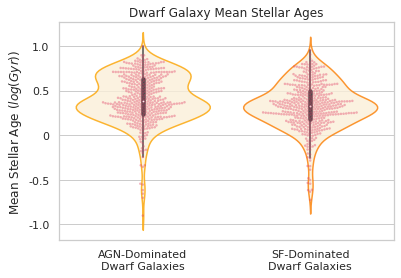

In [30]:
alphas = [0.8, 0.8]
facecolor = ['#FAEFD9','#FAEFD9']
edgecolors = ['#FBA300','#FB7D00']

sns.set(style = 'whitegrid') 

vlnplt = sns.violinplot(data = COMPLETE_PAIRS_LW, scale = 'count')
plt.yticks([-1.0, -0.5, 0, 0.5, 1.0], ['-1.0', '-0.5','0', '0.5', '1.0'])

for violin, alpha in zip(vlnplt.collections[::2], alphas):
    violin.set_alpha(alpha)
    
for pc, color in zip(vlnplt.collections[::2], facecolor):
    pc.set_facecolor(color)

for pc, color in zip(vlnplt.collections[::2], edgecolors):
    pc.set_edgecolor(color)
    
    
srmplt = sns.swarmplot(data = COMPLETE_PAIRS_LW, alpha = 0.4, s = 2.5, color = '#E04166')
srmplt.set_ylabel("Mean Stellar Age " + "$(log(Gyr))$")
srmplt.set_title("Dwarf Galaxy Mean Stellar Ages")
srmplt.set_xticklabels(['AGN-Dominated\nDwarf Galaxies', 'SF-Dominated\nDwarf Galaxies'])

plt.savefig('Dwarf Galaxy Stellar Population Age', dpi = 600, bbox_inches = 'tight')

In [26]:
##=====================================================STATISTICAL ANALYSIS===================================================##

In [27]:
sps.ks_2samp(AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

KstestResult(statistic=0.13859275053304904, pvalue=0.00024002816978182183)

In [29]:
sps.ttest_rel(AGN_PAIR_HALFS_LW, nonAGN_PAIR_HALFS_LW)

Ttest_relResult(statistic=5.38776711355561, pvalue=1.1323206182115966e-07)

In [ ]:
**REPORT MEAN DIFFERENCE AND PVALUE**